# Embedding to non-euclidean spaces with MAP

MAP (Manifold Approximation and Projection) is a lighter version of [UMAP]() with fewer assumptions. It simply performs the graph layout by optimizing the cross-entropy between a similarity graph and an initialized lower-dimensional embedding. The graph construction is conveniently done by TopOMetry with a loose manifold hypothesis only, and a spectral initialization is used.

For the purpose of data visualization, data is usually embedded to a 2D euclidean plane. However, several new studies (particularly involving single-cell data) have pointed to the utility of performing non-euclidean embeddings[1]()[2]()[3](). Here, we show how to perform these embeddings within TopOMetry. Please note this heavily relies on previous work on UMAP.

The key idea is we can embed data to any given space, such as spheres, hyperboloids and so on.


Let's begin installing some basic packages

In [1]:
# Installing some basic packages
#!pip install scanpy pymde umap-learn hnswlib nmslib kneed

In [2]:
# Installing TopOMetry
#!pip install -i https://test.pypi.org/simple/ topometry==0.0.2.7

To start we’ll load the usual selection of libraries.

In [3]:
import scanpy as sc
import topo as tp
%matplotlib inline

As a test dataset we’ll use 3k PBMCs from a Healthy Donor from 10X Genomics available in Scanpy and [here.](https://support.10xgenomics.com/single-cell-gene-expression/datasets/1.1.0/pbmc3k)

In [4]:
adata = sc.datasets.pbmc3k_processed()

After loading the data and QC, instead using PCA for linear dimensional reduction, we can use the TopOGraph to make a diffusion-based dimensional reduction to get the topological metrics that we gonna use on the graphs. 

In [5]:
# Start up the TopOGraph
tg = tp.TopOGraph(n_jobs=12, 
                         verbosity=1,
                         backend='hnwslib',
                         plot_spectrum=True)
tg.fit(adata.X)
db_diff_graph = tg.transform()

# Minimize divergence between the diffusion basis and diffusion graph
emb_db_diff_map = tg.MAP() # by default computes a spectral initialisation

Computing neighborhood graph...
 Base kNN graph computed in 0.968834 (sec)
Building topological basis...using diffusion model.
 Topological basis fitted with multiscale self-adaptive diffusion maps in 4.009577 (sec)
    Building topological graph...
     Topological `diff` graph extracted in = 0.295706 (sec)
         Spectral layout not stored at TopOGraph.SpecLayout. Trying to compute...
         Optimized MAP embedding in = 20.603816 (sec)


Now we need to find the clusters. Here we clustering with leiden

In [6]:
sc.tl.leiden(adata, adjacency=db_diff_graph)

In [7]:
labels = adata.obs['leiden'].astype('int')

# Plane embeddings
TopOMetry works fine even for a plane embedding, the most common and useful way to plot the data.  

We can plot a scatter plotting on a 2D euclidean space.

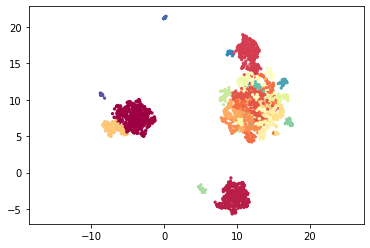

In [8]:
tp.pl.scatter(emb_db_diff_map, labels=labels)

Or a 3D euclidean space.

         Optimized MAP embedding in = 20.987566 (sec)


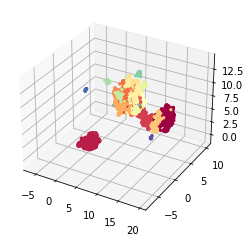

In [9]:
init = tg.spectral_layout(n_components=3)
db_diff_emb3d = tg.MAP(n_components=3, init=init)
tp.pl.scatter3d(db_diff_emb3d, labels=labels)

# Spherical embeddings


Now properly using non-euclidean spaces, we can plot the data as dots on a spherical space.

         Optimized MAP embedding in = 19.752358 (sec)


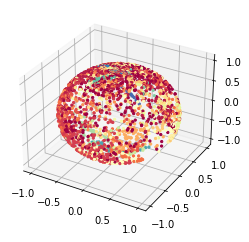

In [10]:
db_diff_sphere = tg.MAP(output_metric='haversine')
tp.pl.sphere(db_diff_sphere, labels=labels)

# Torus embedding

TopOMetry allows you to vizualize your data as a donut, using for this the torus embedding. Torus is a surface of revolution generated by revolving a circle in three-dimensional space about an axis. See more details [here](https://en.wikipedia.org/wiki/Torus)

         Optimized MAP embedding in = 21.147666 (sec)


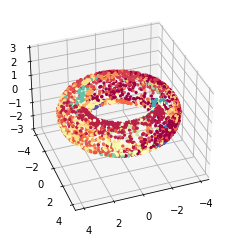

In [11]:
db_diff_map_torus = tg.MAP(n_components=2, output_metric='torus')
tp.pl.toroid(db_diff_map_torus, labels=labels)

# Hyperboloid embedding


On data science, it is common to use hyperbolic representations for hierarchical data (see more context [here](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6534139/)). We can use the [hyperboloid model](https://en.wikipedia.org/wiki/Hyperboloid_model) on TopOMetry to see our data in this space:

         Optimized MAP embedding in = 21.251467 (sec)


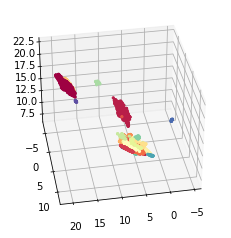

In [12]:
db_diff_map_hyper = tg.MAP(output_metric='hyperboloid')
tp.pl.hyperboloid(db_diff_map_hyper, labels=labels)

Usually, we use [Poincare’s disk model](https://en.wikipedia.org/wiki/Poincar%C3%A9_disk_model) for this visualization of a hyperbolic space.

         Optimized MAP embedding in = 20.321989 (sec)


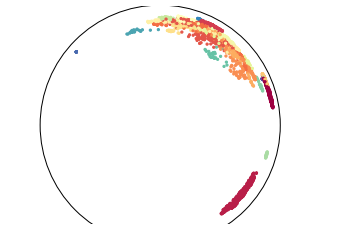

In [13]:
init = tg.spectral_layout(n_components=2)
db_diff_map_poinc = tg.MAP(n_components=2, init=init, output_metric='poincare')
tp.pl.poincare(db_diff_map_poinc, labels=labels)

# Gaussian-Energy Embedding

Unlike most approaches that represent nodes as point vectors in a low-dimensional continuous space, each one with exact values for every parameter, we can embed each node as a Gaussian distribution and infers a probability distribution over all possible values, allowing us to capture uncertainty about the representation. See more context [here](https://doi.org/10.1371/journal.pcbi.1008186) and [here](https://arxiv.org/abs/1707.03815v4)

         Optimized MAP embedding in = 21.749812 (sec)


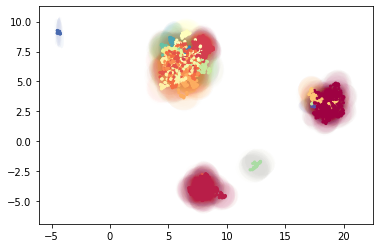

In [14]:
init = tg.spectral_layout(n_components=5)
db_dmap_gauss = tg.MAP(output_metric='gaussian_energy', init=init, n_components=5)
tp.pl.gaussian_potential(db_dmap_gauss, labels=labels)

### That was it for this tutorial!

Let me know if you have any questions. Feel free to [open an issue](https://github.com/davisidarta/topometry/issues) or to contact me via davisidarta@fcm.unicamp.br.